In [1]:
%load_ext autoreload
%autoreload 2

# Multislice Simulations

THe multislice algorithm works by incrementally stepping the 2d lateral part of the wave function forward along the optical axis. A step forward through a slice of the potential consists of a transmission and a propagation. The `Wave` objects can be transmitted through a potential slice, which in the weak-phase approximation is just a phase shift. To complete a forward step the transmitted wave is propagated by the thickness of the slice using in the fresnel approximation.

We import the potential from the previous tutorial and set up a plane wave with an energy of 300 keV.

In [116]:
from abtem.potentials import PrecalculatedPotential
from abtem.waves import PlaneWaves

potential = PrecalculatedPotential.read('srtio3_110_potential.hdf5')
plane_wave = PlaneWaves(energy=300e3)

The plane wave is stepped through the nine'th slice of the potential below.

(<matplotlib.axes._subplots.AxesSubplot at 0x19e8bdf5808>,
 <matplotlib.image.AxesImage at 0x19e8be24e08>)

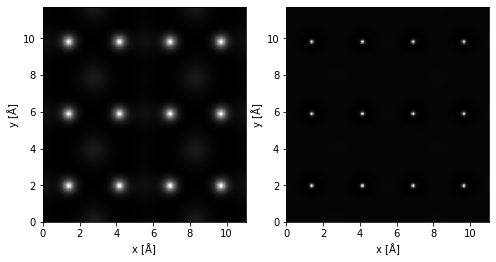

In [117]:
import matplotlib.pyplot as plt

transmitted = plane_wave.transmit(potential[9])
propagated = transmitted.propagate(potential[9].thickness, in_place=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
transmitted.plot(ax=ax1, complex_representation='phase')
propagated.plot(ax=ax2, complex_representation='abs2')

The complete multislice algorithm just repeats this for all slices sequentially, hence it can be implemented as the following loop.

(<matplotlib.axes._subplots.AxesSubplot at 0x19e8be5ec48>,
 <matplotlib.image.AxesImage at 0x19e8be98e48>)

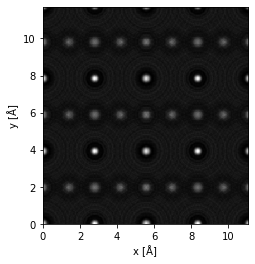

In [118]:
wave = PlaneWaves(energy=300e3)

for potential_slice in potential:
    wave = wave.transmit(potential_slice)
    wave = wave.propagate(potential_slice.thickness)
    
wave.plot()

The above loop is executed by using the `.multislice` method and we store the result

In [119]:
from abtem.potentials import Potential

wave = PlaneWaves(energy=300e3)
exit_wave = wave.multislice(potential)
exit_wave.write('srtio3_exit_wave.hdf5')

## Compatible grids

You may have noted that the extent and sampling of the wave function was not given in the above. Since the potential had a fully defined grid, the wave function just adopts that grid before starting the multislice propagation. On the other hand, the following will result in a runtime error because the sampling cannot be inferred from the information given.

In [ ]:
from abtem.potentials import Potential
from ase.io import 

atoms = read('srtio3.cif')
wave = PlaneWaves(energy=300e3)
potential = Potential(atoms)
exit_wave = wave.multislice(potential)

The next bit of code will also result in an error because the sampling of the wave function and the potential is different.

In [ ]:
wave = PlaneWaves(sampling=.1, energy=300e3)
potential = Potential(sampling=.05, atoms)
exit_wave = wave.multislice(potential)

The code below will run fine, because the extent can be inferred from the atoms and the sampling is given for the wave function

In [ ]:
wave = PlaneWaves(sampling=.1, energy=300e3)
potential = Potential(atoms)
exit_wave = wave.multislice(potential)

## Probe wave function multislice simulation

Imaging modes utilizing an electron probe requires running the multislice algorithm for each position.

In [102]:
from abtem.waves import ProbeWaves

potential = PrecalculatedPotential.read('srtio3_110_potential.hdf5')

probe = ProbeWaves(energy=200e3, semiangle_cutoff=.02)

exit_wave = probe.multislice_at((5.,6.), potential, show_progress=False)

(<matplotlib.axes._subplots.AxesSubplot at 0x19e8d279148>,
 <matplotlib.image.AxesImage at 0x19e8d291f08>)

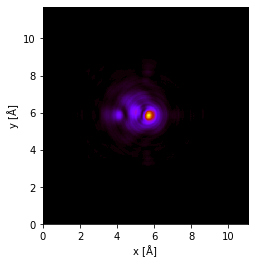

In [103]:
exit_wave.plot(cmap='gnuplot')

In convergent beam electron diffraction, we want the intensity of wave function at the diffraction plane. This is equivalent to the power spectra of the wave function. This can be calculated

The square modulus of the Fourier transform of a function is called its power spectra. The power spectra of the wave function transmitted through the specimen is also equivalent to the electron diffraction pattern of the specimen. numpy can be used for calculate the power spectra of a wave function.

In [110]:
diffraction_patterns = exit_wave.diffraction_patterns()

In [104]:
diffraction_pattern = np.abs(np.fft.fftshift(np.fft.fft2(exit_wave.array))) ** 2

The `plot` method can be used for displaying diffraction patterns by setting `fourier_space = True`. A diffraction pattern typically has a very large dynamic range in its intensity. The low spatial frequency information (low scattering angle) has a large amplitude but the high spatial frequency information (high scattering angle) has a much lower amplitude. The high spatial frequency information (which is frequently the interesting part) is not visible if the diffraction pattern is normalized to fill the available grey scale in a linear manner. It is to common to transform the intensities as:

$$
\log(1 + c |F(k_x,k_y)|^2) \quad ,
$$

where $F(k_x, k_y)$ is the Fourier transform of the image and the constant $c$ can be varied to adjust the contrast.

(<matplotlib.axes._subplots.AxesSubplot at 0x19e8d321b08>,
 <matplotlib.image.AxesImage at 0x19e8d360688>)

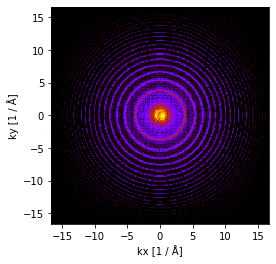

In [106]:
exit_wave.plot(fourier_space=True, logscale=True, logscale_constant=.000010, cmap='gnuplot')